<h2> Import Requirements </h2>

In [1]:
!pip3 install impyute
!pip install -U scikit-learn

You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-learn in /home/nbuser/anaconda3_420/lib/python3.5/site-packages (0.21.2)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice

<h2> Load Necessary Data </h2>

In [3]:
alldata = pd.read_csv("sp500alldata.csv", error_bad_lines=False)
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2566 entries, 0 to 2565
Columns: 132 entries, date to firm
dtypes: float64(130), object(2)
memory usage: 2.6+ MB


In [4]:
constdata = pd.read_csv("constituents_csv.csv", error_bad_lines=False)
constdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 3 columns):
Symbol    505 non-null object
Name      505 non-null object
Sector    505 non-null object
dtypes: object(3)
memory usage: 11.9+ KB


In [5]:
econdata = pd.read_csv("annualecondata.csv", error_bad_lines=False)
econdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
Date       58 non-null int64
Value_x    58 non-null float64
Value_y    58 non-null float64
Value      43 non-null float64
dtypes: float64(3), int64(1)
memory usage: 1.9 KB


In [6]:
stockconf = pd.read_csv("stockconfidencedata.csv", error_bad_lines=False)
stockconf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 3 columns):
Date              221 non-null int64
Index Value       221 non-null float64
Standard Error    221 non-null float64
dtypes: float64(2), int64(1)
memory usage: 5.3 KB


<h2> Prepare Consolidated Dataset </h2>

<b> STEP 1: Dimension Cleaning </b>

While most of the data is 5-year worth of yearly information, some errenous entries have far more frequent information - monthly, quarterly etc., owing to irregularities in data collection. Since dividend payments are considered yearly, such errenous values must be dealt with

In [7]:
alldata.sort_values(by=['firm', 'date'], ascending = [True, True], inplace=True)
alldata.reset_index(drop=True, inplace=True)

In [8]:
alldata.date.apply(lambda s: 'VALID' if str(s)[0].isnumeric() else s).value_counts(dropna=False)

VALID         2560
Unnamed: 1       6
Name: date, dtype: int64

In [9]:
firms = alldata[alldata.date=='Unnamed: 1'].firm
alldata = alldata[(~(alldata.firm.isin(firms)))]

In [10]:
counter = alldata.date.apply(lambda s: int(s.split("-")[0]))
rmv = alldata.loc[(counter.diff().shift(-1)==0) & (alldata.firm == alldata.firm.shift(-1)), ['date', 'firm']]
rmv.firm.unique()

array(['EVHC', 'HBI', 'NFX', 'NWS', 'SCG', 'UA', 'YUM'], dtype=object)

In [11]:
alldata.drop(rmv.index, inplace=True)

<b> STEP 2: Missing Value Deletions </b>

We first analyze the number of missing values across columns and decide to drop any above 60%. As seen below, 21 of the 168 columns meet this requirement. Out of these, however, investments in research and development is considered an important factor for a firm, and is hence kept.

In [12]:
x = alldata.apply(lambda s: 1 if (sum(s.isnull() * 1)) > 0.6 * len(s) else np.nan).dropna()
x

Operating expenses                      1.0
Research and development                1.0
Other                                   1.0
Earnings per share                      1.0
Weighted average shares outstanding     1.0
Assets                                  1.0
Current assets                          1.0
Cash                                    1.0
Short-term investments                  1.0
Non-current assets                      1.0
Property, plant and equipment           1.0
Equity and other investments            1.0
Prepaid pension benefit                 1.0
Liabilities and stockholders' equity    1.0
Liabilities                             1.0
Current liabilities                     1.0
Non-current liabilities                 1.0
Capital leases                          1.0
Pensions and other benefits             1.0
Minority interest                       1.0
Stockholders' equity                    1.0
dtype: float64

In [13]:
coldel = np.delete(x.index.values, np.where(x.index.values=='Research and development')[0])
alldata.drop(coldel, axis=1, inplace=True)

In [14]:
#We now analyze the number of null values per company. While most companies have 5 rows (5 years), some have fewer and so we need to make
#sure that the firms where np.nan exceeds 60% of values are removed. We can use value_counts() to retrieve how many rows a firm has
rownum = alldata.firm.value_counts()
rownum = rownum[alldata.firm.unique()]
#Having retrived correct row counts, we now get null numbers for each company
nullnum = alldata.apply(lambda s: sum(s.isnull() * 1), axis=1)
nullnum = np.cumsum(nullnum)
changeorg = nullnum.where(alldata.firm != alldata.firm.shift(1)).ffill().fillna(0)
nullnum = nullnum - changeorg
nullnum = nullnum.where(alldata.firm != alldata.firm.shift(-1)).dropna()
nullnum.index = alldata.firm.unique()
nval = nullnum[nullnum >= 0.6 * rownum * 148]
nval

NFX    535.0
NWS    535.0
dtype: float64

In [15]:
firmstodrop = nval.index.values
indices = alldata[alldata.firm.isin(firmstodrop)].index.values
alldata.drop(indices, axis=0, inplace=True)
alldata.reset_index(drop=True, inplace=True)

In [16]:
#Special adjustment based on quality, relevance and repetition of data involved
#The columns involved below are  repetitions or correlations of existing financial metrics, thus crowding analysis
badcols = ['Net income from continuing operations', 'Net income available to common shareholders', 
           'Cash and cash equivalents', 'Current ratio','Debt to Equity','ROE', 'ROIC', 
           'Receivables Turnover','Return on Tangible Assets', 
           'Tangible Asset Value','Working Capital']
alldata.drop(badcols, axis=1, inplace=True)

<b> STEP 3: Merge Supplementary Data </b>

We must combine the main S&P500 financial dataset with the economics, stock confidence and sector data that was collected simultaneously. Sector data is merged on firm, annual economics on year and stock confidence on month. Relevant features are temporarily added to facilitate such merges.

In [17]:
constdata.rename(columns={'Symbol':'firm'}, inplace=True)
alldata = alldata.merge(constdata[['firm', 'Sector']], on='firm', how='left')

In [18]:
cols = econdata.columns.values
vals = ['Year','GDP', 'GNI', 'Market_Cap']
econdata.rename(columns = dict(zip(cols, vals)), inplace=True)
econdata.Year = econdata.Year.apply(lambda s: int(s/100))
alldata['Year'] = alldata.date.apply(lambda s: int(s.split('-')[0]))

In [19]:
#Front fill to latest economics entry required before merging
latestecon = econdata.sort_values(by='Year', ascending=False).iloc[0]
curtime = alldata.Year.max()
newvals = econdata.loc[np.array([0]).repeat(curtime - latestecon.Year)].copy()
adj = pd.Series(np.arange(curtime - latestecon.Year) + 1)
newvals.reset_index(drop=True, inplace=True)
newvals['Year'] = newvals['Year'] + adj
econdata = econdata.append(newvals)
econdata.sort_values(by='Year', ascending=False, inplace=True)
econdata = econdata[econdata.Year >= alldata.Year.min()]
econdata.reset_index(drop=True, inplace=True)

In [20]:
econdata.Year = econdata.Year.astype('int')
alldata = alldata.merge(econdata, on='Year', how='left')
alldata.drop(['Year'], axis=1, inplace=True)

In [21]:
def yearshift(base, amt):
    mth = base % 100
    year = (base - mth)/100
    mth = mth + amt
    if mth > 12:
        year = year + (mth - (mth % 12))/12
        mth = mth % 12
    return int(year * 100 + mth)

In [22]:
def mthdiff (val1, val2):
    endyear = int(val1/100)
    endmonth = val1 % 100
    startyear = int(val2/100)
    startmonth = val2 % 100
    return (endyear - startyear) * 100 + (endmonth - startmonth)

In [23]:
#Front fill to latest stock confidence values required before merging
stockconf.rename(columns={'Date':'date'}, inplace=True)
alldata.date = alldata.date.apply(lambda s: int(s.split('-')[0] + s.split('-')[1]))
conflatest = stockconf.date.max()
curperiod = alldata.date.max()
newvals = stockconf.loc[np.array([stockconf.loc[stockconf.date==conflatest].index[0]]).repeat(mthdiff(curperiod, conflatest))]
newvals.reset_index(drop=True, inplace=True)
adj = pd.Series(np.arange(mthdiff(curperiod, conflatest)) + 1)
newvals['date'] = newvals['date'].astype('str') + ' ' + adj.astype('str')
newvals['date'] = newvals['date'].apply(lambda s: yearshift(int(s.split()[0]), int(s.split()[1])))

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
stockconf = stockconf.append(newvals)
stockconf.sort_values(by='date', ascending=False)
stockconf = stockconf[stockconf.date >= alldata.date.min()]
stockconf.reset_index(drop=True, inplace=True)
alldata = alldata.merge(stockconf, on='date', how='left')
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Columns: 107 entries, date to Standard Error
dtypes: float64(104), int64(1), object(2)
memory usage: 1.9+ MB


<h2> Missing Value Imputation </h2>

The strategy for imputation we decided to adopt was three-pronged. First, we attempt to calculate income and balance sheet values (not ratios), if possible from other corresponding columns, like Revenue = Grossprofit + Cost of revenue, etc. We repeat this for income statement and balance sheet variables (since such corrections exist), until no better values can be figured. For remaining null values, in the second stage, we fill all nulls in a column with a company-by-company average of non-null figures. In the third stage, if such missing values continue to persist, we  impute them with  average value from their sector of operations. Finally, we re-calculate all ratios from the new information gained by performing the three stages on income/balance sheet data, and any ratio outside the scope of such calculation is filled again by sklearn's Imputer

<b> STEP 1: Internal Calculations </b>

In [25]:
#Income statement variables
#We repeat it till it is able to make no more difference
oldnullinc = np.inf
curnullinc = alldata.apply(lambda s: sum(s.isnull()))[:13].values.sum()
while curnullinc < oldnullinc:
    alldata.loc[alldata.Revenue.isnull(), "Revenue"] = alldata["Gross profit"] + alldata["Cost of revenue"]
    alldata.loc[alldata['Cost of revenue'].isnull(), "Cost of revenue"] = alldata["Revenue"] - alldata["Gross profit"]
    alldata.loc[alldata['Gross profit'].isnull(), "Gross profit"] = alldata["Revenue"] - alldata["Cost of revenue"]
    alldata.loc[alldata['Gross profit'].isnull(), "Gross profit"] = alldata["Operating income"] + alldata["Total operating expenses"]
    alldata.loc[alldata['Total operating expenses'].isnull(), "Total operating expenses"] = alldata["Gross profit"] - alldata["Operating income"]
    alldata.loc[alldata['Operating income'].isnull(), "Operating income"] = alldata["Gross profit"] - alldata["Total operating expenses"]
    alldata.loc[alldata['Operating income'].isnull(), "Operating income"]  = alldata["Income before taxes"] - alldata['Other income (expense)'] + alldata['Interest Expense']
    alldata.loc[alldata['Interest Expense'].isnull(), "Interest Expense"] = alldata['Operating income'] + alldata['Other income (expense)'] - alldata['Income before taxes']
    alldata.loc[alldata['Other income (expense)'].isnull(), "Other income (expense)"] = alldata["Income before taxes"] + alldata["Interest Expense"] - alldata["Operating income"]
    alldata.loc[alldata['Income before taxes'].isnull(), "Income before taxes"] = alldata['Operating income'] - alldata['Interest Expense'] + alldata['Other income (expense)']
    alldata.loc[alldata['Income before taxes'].isnull(), "Income before taxes"] = alldata['Net income'] + alldata['Provision for income taxes']
    alldata.loc[alldata['Provision for income taxes'].isnull(), "Provision for income taxes"] = alldata["Income before taxes"] - alldata["Net income"]
    alldata.loc[alldata['Net income'].isnull(), "Net income"] = alldata['Income before taxes'] - alldata['Provision for income taxes']
    oldnullinc = curnullinc
    curnullinc = alldata.apply(lambda s: sum(s.isnull()))[:13].values.sum()
    print(curnullinc)

print("Income values done")

8544
8347
8347
Income values done


In [26]:
#Balance sheet variables
#We repeat till it is able to make no more difference, similarly as above
oldnullinc = np.inf
curnullinc = alldata.apply(lambda s: sum(s.isnull()))[16:48].values.sum()
while curnullinc < oldnullinc:
    alldata.loc[alldata['Total current assets'].isnull(), "Total current assets"] = alldata['Total cash'] + alldata['Receivables'] + alldata['Inventories'] + alldata['Prepaid expenses'] + alldata['Other current assets']
    alldata.loc[alldata['Total cash'].isnull(), "Total cash"] = alldata['Total current assets'] - alldata['Receivables'] - alldata['Inventories'] - alldata['Prepaid expenses'] - alldata['Other current assets']
    alldata.loc[alldata['Receivables'].isnull(), "Receivables"] = alldata['Total current assets'] - alldata['Total cash'] - alldata['Inventories'] - alldata['Prepaid expenses'] - alldata['Other current assets']
    alldata.loc[alldata['Inventories'].isnull(), "Inventories"] = alldata['Total current assets'] - alldata['Receivables'] - alldata['Total cash'] - alldata['Prepaid expenses'] - alldata['Other current assets']
    alldata.loc[alldata['Prepaid expenses'].isnull(), "Prepaid expenses"] = alldata['Total current assets'] - alldata['Receivables'] - alldata['Inventories'] - alldata['Total cash'] - alldata['Other current assets']
    alldata.loc[alldata['Other current assets'].isnull(), "Other current assets"] = alldata['Total current assets'] - alldata['Receivables'] - alldata['Inventories'] - alldata['Prepaid expenses'] - alldata['Total cash']
    alldata.loc[alldata['Gross property, plant and equipment'].isnull(), "Gross property, plant and equipment"] = alldata['Net property, plant and equipment'] - alldata['Accumulated Depreciation']
    alldata.loc[alldata['Accumulated Depreciation'].isnull(), "Accumulated Depreciation"] = alldata['Net property, plant and equipment'] - alldata['Gross property, plant and equipment']
    alldata.loc[alldata['Net property, plant and equipment'].isnull(), 'Net property, plant and equipment'] = alldata['Gross property, plant and equipment'] + alldata['Accumulated Depreciation']
    alldata.loc[alldata['Net property, plant and equipment'].isnull(), 'Net property, plant and equipment'] = alldata['Total non-current assets'] - alldata['Goodwill'] - alldata['Intangible assets'] - alldata['Other long-term assets']
    alldata.loc[alldata['Goodwill'].isnull(), "Goodwill"] = alldata['Total non-current assets'] - alldata['Net property, plant and equipment'] - alldata['Intangible assets'] - alldata['Other long-term assets']
    alldata.loc[alldata['Intangible assets'].isnull(), "Intangible assets"] = alldata['Total non-current assets'] - alldata['Goodwill'] - alldata['Net property, plant and equipment'] - alldata['Other long-term assets']
    alldata.loc[alldata['Other long-term assets'].isnull(), "Other long-term assets"] = alldata['Total non-current assets'] - alldata['Goodwill'] - alldata['Intangible assets'] - alldata['Net property, plant and equipment']
    alldata.loc[alldata['Total non-current assets'].isnull(), "Total non-current assets"] = alldata['Net property, plant and equipment'] + alldata['Goodwill'] + alldata['Intangible assets'] + alldata['Other long-term assets']
    alldata.loc[alldata['Total assets'].isnull(), 'Total assets']  = alldata['Total current assets'] + alldata['Total non-current assets']
    alldata.loc[alldata['Total current assets'].isnull(), "Total current assets"] = alldata['Total assets'] - alldata['Total non-current assets']
    alldata.loc[alldata['Total non-current assets'].isnull(), 'Total non-current assets'] = alldata['Total assets'] - alldata['Total current assets']
    
    alldata.loc[alldata['Short-term debt'].isnull(), "Short-term debt"] = alldata['Total current liabilities'] - alldata['Other current liabilities'] - alldata['Accrued liabilities'] - alldata['Taxes payable'] - alldata['Accounts payable']
    alldata.loc[alldata['Accounts payable'].isnull(), "Accounts payable"] = alldata['Total current liabilities'] - alldata['Other current liabilities'] - alldata['Accrued liabilities'] - alldata['Taxes payable'] - alldata['Short-term debt']
    alldata.loc[alldata['Taxes payable'].isnull(), "Taxes payable"] = alldata['Total current liabilities'] - alldata['Other current liabilities'] - alldata['Accrued liabilities'] - alldata['Short-term debt'] - alldata['Accounts payable']
    alldata.loc[alldata['Accrued liabilities'].isnull(), "Accrued liabilities"] = alldata['Total current liabilities'] - alldata['Other current liabilities'] - alldata['Short-term debt'] - alldata['Taxes payable'] - alldata['Accounts payable']
    alldata.loc[alldata['Other current liabilities'].isnull(), "Other current liabilities"] = alldata['Total current liabilities'] - alldata['Short-term debt'] - alldata['Accrued liabilities'] - alldata['Taxes payable'] - alldata['Accounts payable']
    alldata.loc[alldata['Total current liabilities'].isnull(), "Total current liabilities"] = alldata['Short-term debt'] + alldata['Other current liabilities'] + alldata['Accrued liabilities'] + alldata['Taxes payable'] + alldata['Accounts payable']
    alldata.loc[alldata['Long-term debt'].isnull(), "Long-term debt"] = alldata['Total non-current liabilities'] - alldata['Other long-term liabilities'] - alldata['Deferred taxes liabilities']
    alldata.loc[alldata['Deferred taxes liabilities'].isnull(), "Deferred taxes liabilities"] = alldata['Total non-current liabilities'] - alldata['Other long-term liabilities'] - alldata['Long-term debt']
    alldata.loc[alldata['Other long-term liabilities'].isnull(), "Other long-term liabilities"] = alldata['Total non-current liabilities'] -alldata['Long-term debt'] - alldata['Deferred taxes liabilities']
    alldata.loc[alldata['Total non-current liabilities'].isnull(), "Total non-current liabilities"] = alldata['Long-term debt'] + alldata['Other long-term liabilities'] + alldata['Deferred taxes liabilities']
    alldata.loc[alldata['Total liabilities'].isnull(), "Total liabilities"]  = alldata['Total current liabilities'] + alldata['Total non-current liabilities']
    alldata.loc[alldata['Total current liabilities'].isnull(), "Total current liabilities"] = alldata["Total liabilities"] - alldata['Total non-current liabilities']
    alldata.loc[alldata['Total non-current liabilities'].isnull(), "Total non-current liabilities"] = alldata['Total liabilities'] - alldata['Total current liabilities']
    
    alldata.loc[alldata['Common stock'].isnull(), "Common stock"] = alldata["Total stockholders' equity"] - alldata["Accumulated other comprehensive income"] - alldata['Treasury stock'] - alldata['Retained earnings'] - alldata['Additional paid-in capital']
    alldata.loc[alldata['Additional paid-in capital'].isnull(), "Additional paid-in capital"] = alldata["Total stockholders' equity"] - alldata["Accumulated other comprehensive income"] - alldata['Treasury stock'] - alldata['Retained earnings'] - alldata['Common stock']
    alldata.loc[alldata['Retained earnings'].isnull(), "Retained earnings"] = alldata["Total stockholders' equity"] - alldata["Accumulated other comprehensive income"] - alldata['Treasury stock'] - alldata['Common stock'] - alldata['Additional paid-in capital']
    alldata.loc[alldata['Treasury stock'].isnull(), "Treasury stock"] = alldata["Total stockholders' equity"] - alldata["Accumulated other comprehensive income"] - alldata['Common stock'] - alldata['Retained earnings'] - alldata['Additional paid-in capital']
    alldata.loc[alldata['Accumulated other comprehensive income'].isnull(), "Accumulated other comprehensive income"] = alldata["Total stockholders' equity"] - alldata["Common stock"] - alldata['Treasury stock'] - alldata['Retained earnings'] - alldata['Additional paid-in capital']
    alldata.loc[alldata["Total stockholders' equity"].isnull(), "Total stockholders' equity"] = alldata["Common stock"] + alldata["Accumulated other comprehensive income"] + alldata['Treasury stock'] + alldata['Retained earnings'] + alldata['Additional paid-in capital']
    
    alldata.loc[alldata["Total liabilities and stockholders' equity"].isnull(), "Total liabilities and stockholders' equity"] = alldata['Total liabilities'] + alldata["Total stockholders' equity"]
    alldata.loc[alldata["Total stockholders' equity"].isnull(), "Total stockholders' equity"] = alldata["Total liabilities and stockholders' equity"] - alldata['Total liabilities']
    alldata.loc[alldata['Total liabilities'].isnull(), "Total liabilities"] = alldata["Total liabilities and stockholders' equity"] - alldata["Total stockholders' equity"]
    alldata.loc[alldata["Total assets"].isnull(), "Total assets"] = alldata["Total liabilities and stockholders' equity"]
    alldata.loc[alldata["Total liabilities and stockholders' equity"].isnull(), "Total liabilities and stockholders' equity"] = alldata["Total assets"]
    
    oldnullinc = curnullinc
    curnullinc = alldata.apply(lambda s: sum(s.isnull()))[16:48].values.sum()
    print (curnullinc)

print("balance sheet variables done")

18661
18559
18559
balance sheet variables done


In [28]:
#If any incorrect values (eg. negative stockholder's equity, liabilities > assets etc., these are set to np.nan, and left for imputation)
nonneg = set(alldata.columns.values) - set(['Other income (expense)', 'firm', 'Sector'])
for col in nonneg:
    alldata.loc[alldata[col] < 0, col] = np.nan
#Special edge cases
alldata.loc[alldata['Cost of revenue'] > alldata['Revenue'], ['Cost of revenue', 'Revenue', 'Gross profit']] = np.nan
alldata.loc[alldata['Total assets'] < alldata['Total liabilities'], ['Total assets', 'Total liabilities']] = np.nan
alldata.loc[alldata['Total current liabilities'] > alldata['Total liabilities'], ['Total current liabilities', 'Total non-current liabilities', 'Total liabilities']] = np.nan
alldata.loc[alldata['Total non-current liabilities'] > alldata['Total liabilities'], ['Total current liabilities', 'Total non-current liabilities', 'Total liabilities']] = np.nan


In [29]:
#Other calculations
alldata.loc[alldata.Basic_EPS.isnull(), "Basic_EPS"] = alldata["Diluted_EPS"]
alldata.loc[alldata.Diluted_EPS.isnull(), "Diluted_EPS"] = alldata["Basic_EPS"]
alldata.loc[alldata.EBITDA.isnull(), "EBITDA"] = alldata["Income before taxes"] + alldata["Interest Expense"]

<b> STEP 2: Average Value Imputation - Historic Company Values and Sector Values </b>

In [30]:
#Historic Company Averages
def correct(row, col, vals):
    if (str(row[col])=='nan') & (vals[row['firm']] != 0):
        row[col] = vals[row['firm']]
    return row

def histcompavg (var):
    if np.where(alldata.columns.values==var.name)[0][0] in range(1,48):
        rev = np.cumsum(var).ffill()
        rev = rev - (rev.where(alldata.firm != alldata.firm.shift(-1))).shift(1).ffill().fillna(0)
        rev = rev[alldata.firm != alldata.firm.shift(-1)]
        rev.index = alldata.firm.unique()
        rownum = alldata.firm.value_counts()
        rownum = rownum[alldata.firm.unique()]
        rev = rev / rownum
        x = pd.concat([var, alldata.firm], axis=1)
        x = x.apply(lambda s: correct(s, var.name, rev), axis=1)
        x[var.name] = x[var.name].apply(lambda s: round(s,2))
        return x[var.name]
    else:
        return var

alldata = alldata.apply(lambda s: histcompavg(s))

In [31]:
#Analyze sector composition
alldata.Sector.value_counts(dropna=False)

Consumer Discretionary        342
Industrials                   329
Financials                    329
Information Technology        310
Health Care                   292
Real Estate                   153
Energy                        152
Consumer Staples              143
Utilities                     140
Materials                     119
Telecommunication Services     15
Name: Sector, dtype: int64

In [32]:
#Derive sector averages
#We calculate sector averages below for all income and balance sheet variables. In addition, we need to handle 3 stock variables.
#We have exactly two firms - FOX and FOXA (Consumer Discretionary) - that do not have any stock price recordings. Given that all these
#companies are S&P500, it is safe to assume that companies in the same industry will average out around the same stock price
#Moreover, only 7-8 recordings are affected by the same.
def sectavg (var):
    if np.where(alldata.columns.values==var.name)[0][0] in np.append(np.arange(48)+1, np.array([97,98,99])):
        industries = alldata.loc[var.isnull(), "Sector"].dropna().unique()
        for ind in industries:
            comm = np.sum(alldata.loc[alldata.Sector==ind, var.name])/ len(alldata.loc[alldata.Sector==ind, var.name])
            var[(alldata.Sector==ind) & var.isnull()] = round(comm, 2)
    return var

alldata = alldata.apply(lambda s: sectavg(s))

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<b> STEP 3: Algorithmic Imputers </b>

After having eliminated all missing values in balance and income statements, we need algorithmic imputers - scikitlearn's preprocessing functions or impyute's knn and mice systems, to fill the remainder of values, before proceeding to feature engineering. For this final stage of data cleaning, we divide our features into 4 buckets - noact (no imputation; a fillna to be called), calc (ratios that can easily be calculated from other completed values), knnalg (ratios that cant be calculated but are closely linked to income/balance sheet values and so nearest neighbours is an ideal approach), and simimp (ratios that are finally not closely linked to available values and must be directly imputed).

In [33]:
#Declare the final method of imputation for key metrics variables, mostly existing imputation algorithms
#These variables determine the response indicator and thus cannot be imputed
noact = ['Dividend Yield', 'Payout Ratio']
#These are calculated using known financial formulae
calc = ['Net Debt to EBITDA', 'SG&A to Revenue', 'Debt to Assets', 
        'Intangibles to Total Assets', 'R&D to Revenue']
#These are closely linked to values we calculated above and thus nearest neighbour is apt
knnalg = ['Average Inventory','Average Payables', 'Average Receivables', 'Book Value per Share',
          'Capex per Share', 'Capex to Depreciation', 'Days Payables Outstanding', 
          'Days of Inventory on Hand','Inventory Turnover','Invested Capital', 'Market Cap', 
          'Net Current Asset Value','Payables Turnover']
#We do not have enough information to closely match or calculate these already and thus use Imputer
simimp = ['Revenue per Share', 'Shareholders Equity per Share','EV to Operating cash flow',
          'Stock-based compensation to Revenue','Tangible Book Value per Share', 
          'Capex to Operating Cash Flow','Capex to Revenue','Cash per Share',
          'Days Sales Outstanding','EV to Free cash flow','EV to Sales','Earnings Yield',
          'Enterprise Value','Enterprise Value over EBITDA','Free Cash Flow Yield', 
          'Free Cash Flow per Share','Graham Net-Net','Graham Number','Income Quality',
          'Interest Coverage','Interest Debt per Share','Net Income per Share',
          'Operating Cash Flow per Share','PB ratio','PE ratio','PFCF ratio', 'POCF ratio', 
          'PTB ratio','Price to Sales Ratio']

In [34]:
#Deal with noact and calc first
for i in noact:
    alldata[i] = alldata[i].fillna(0)
alldata.loc[alldata[calc[0]].isnull(), calc[0]] = alldata['Total liabilities'] / alldata['EBITDA']
alldata.loc[alldata[calc[1]].isnull(), calc[1]] = alldata['Sales, General and administrative'] / alldata['Revenue']
alldata.loc[alldata[calc[2]].isnull(), calc[2]] = alldata['Total liabilities'] / alldata['Total assets']
alldata.loc[alldata[calc[3]].isnull(), calc[3]] = alldata['Intangible assets'] / alldata['Total assets']
alldata.loc[alldata[calc[4]].isnull(), calc[4]] = alldata['Research and development'] / alldata['Revenue']

In [35]:
#Handle knnalg imputations
relevdata = alldata[np.append(alldata.columns.values[1:48], knnalg)]
relevdata = fast_knn(relevdata, k=5)
alldata.drop(knnalg, axis=1, inplace=True)
relevdata = relevdata.iloc[:, 47:]
cur = relevdata.columns.values
relevdata.rename(columns=dict(zip(cur, knnalg)), inplace=True)
alldata = pd.concat([alldata, relevdata], axis=1)

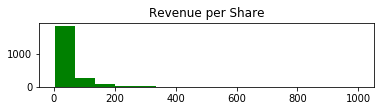

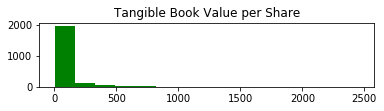

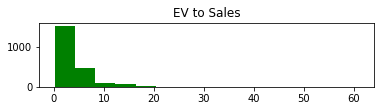

In [36]:
#Explore feasible method of simple imputation based on value distribution
#Here, we choose three random variables and plot these to get a general idea
plt.subplot(311)
plt.hist(alldata[simimp[0]].sort_values().dropna().values, bins=15, color='green')
plt.title(simimp[0])
plt.show()
plt.subplot(312)
plt.hist(alldata[simimp[4]].sort_values().dropna().values, bins=15, color='green')
plt.title(simimp[4])
plt.show()
plt.subplot(313)
plt.hist(alldata[simimp[10]].sort_values().dropna().values, bins=15, color='green')
plt.title(simimp[10])
plt.show()

Since the distributions are clearly right-skewed, using 'mean' approach to impute missing values would likely lead to general over-estimates. Thus, since the data is not normal, we have two approaches: either power-transform the data into a normal distribution and then impute with mean, or just directly impute with median. To preserve the actual current values for the variables, the latter approach has been chosen. Therefore, scikitlearn's Imputer is used with the 'median' strategy.

In [37]:
imp = Imputer(missing_values=np.nan, strategy='median')
for col in simimp:
    vals = alldata[col].values.reshape(-1,1)
    newvals = imp.fit_transform(vals).reshape(1,-1)
    alldata[col] = newvals[0]

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [38]:
#All missing values have been successfully imputed
#Save cleaned file before proceeding to feature engineering
alldata.to_pickle('sp500cleandata.pkl')
alldata.apply(lambda s: sum(s.isnull()) if sum(s.isnull()) > 0 else np.nan).dropna()

Series([], dtype: float64)

<h2> Feature Engineering </h2>

In this section, we engineer three varied buckets of features for the data - dividend values and attributes (amount, frequency and distance from payment), company characteristics (composition in the SP500 or industry on the basis of market cap etc.), and numerous financial ratios. This helps balance 'static' and 'dynamic' variables in our final data,  making it more representative and predictive of our response variable. After feature engineering, we proceed to model training.

<b> STEP 1: Dividend-Based Features

Dividends can be calculated as either Payout Ratio * Earnings per Share or Dividend Yield * Stock Price. While these mathematically-yield close results, they cause a small an average difference of 0.13 cents on our data. Hence, the dividend value used in model training is the average of these two approaches. Subsequently, after dynamic dividend features are engineered, the payout ratio and yield are dropped as these cannot be known prior to dividend declaration and thus have no net predictive or applicable value in our pipeline.

In [8]:
alldata = pd.read_pickle('../data/sp500cleandata.pkl')

In [9]:
x = alldata['Dividend Yield'] * alldata['stockprc']
y = alldata['Payout Ratio'] * alldata['Basic_EPS']
#Average error in two approaches to dividend
print(sum(x-y)/len(x))
alldata['Dividend'] = (x + y)/2

-0.09035920830895001


In [10]:
alldata.Dividend.apply(lambda s: 'PAID'  if s > 0 else 'UNPAID').value_counts(dropna=False)

PAID      1873
UNPAID     451
Name: Dividend, dtype: int64

In [11]:
#Dynamic payment duration variables
alldata['Div_Paid?'] = alldata.Dividend.apply(lambda s: 1 if s > 0 else 0)
#When attempting to check whether the company has paid dividend in the previous year, we would have to drop the first recording for
#every firm since such data would be unavailable. However, since we already have limited data available from the API, it would 
#significantly reduce our training set and affect the applicability of the model. To get around it, we derive estimations for this
#first recording. As such, we assign a 1 (last dividend paid) if the company has paid a special majority of more dividends 
#than not in recorded history, else 0. The reason we are stricter at a 0.67 requirement than 0.5 is to ensure greater certainty in
#the fundamental dividend features in our model
row = np.cumsum(pd.Series(np.ones(len(alldata))))
track = np.cumsum(alldata['Div_Paid?'])
row = row - row.where(alldata.firm != alldata.firm.shift(-1)).shift(1).ffill().fillna(0)
track = track - track.where(alldata.firm != alldata.firm.shift(-1)).shift(1).ffill().fillna(0)
row = row.where(alldata.firm != alldata.firm.shift(-1)).bfill()
track = track.where(alldata.firm != alldata.firm.shift(-1)).bfill()
track = track/row
track = track.where(alldata.firm != alldata.firm.shift(1)).fillna(0)
track = track.apply(lambda s: 1 if s > 0.67 else 0)
alldata['Paid_LastYr?'] = alldata['Div_Paid?'].shift(1)
alldata.loc[alldata.firm != alldata.firm.shift(1), 'Paid_LastYr?'] = 0
alldata['Paid_LastYr?'] = alldata['Paid_LastYr?'] + track

In [12]:
#We now define a categorical variable - distance from last dividend. It can either be 1-5 or UNKNOWN. The reason this is being treated
#as discrete not continuous is to allow the fact that since companies have existed for long durations, imputing unavailable data may lead
#to excessive engineering of the training set, not being representative of the original data itself.
dist = alldata['Paid_LastYr?'].map({1:0, 0:1})
dist = np.cumsum(dist)
dist = dist - dist.where(alldata.firm != alldata.firm.shift(-1)).shift(1).ffill().fillna(0)
alldata['DistanceFromLast'] = dist + 1
alldata['DistanceFromLast'] = alldata['DistanceFromLast'].astype('int').astype('str')
alldata.loc[alldata.firm != alldata.firm.shift(1), "DistanceFromLast"] = 'UNKNOWN'

We now try to find the proportion of industry that paid last year. Since the bulk of our data lies in 2014-2018, these years have enough samples to provide reliable estimates for this value. However, 2013 and 2019, seen below, have very few samples. Thus, we impute 2014's readings to 2013, and 2018's readings to 2019. This should not severely affect the model, given only 13 recordings total in consideration.

In [13]:
alldata['Year'] = alldata['date'].apply(lambda s: int(s/100))
alldata.drop(['date'], axis=1, inplace=True)
alldata.Year.value_counts()

2017    486
2016    473
2018    463
2015    458
2014    431
2013      8
2019      5
Name: Year, dtype: int64

In [14]:
#We first create a table with the year and sector wise cumulations of paid_lastyr? to determine prop of sector that paid
vals = alldata[['Year', 'Sector', 'Paid_LastYr?']]
vals.sort_values(by=['Sector', 'Year'], ascending=True, inplace=True)
vals.reset_index(drop=True, inplace=True)
#Since the data is first sorted on sector, we can use year as the divider between individual cumulative sums
vals['Total'] = pd.Series(np.arange(len(vals)) + 1)
vals['Total'] = vals['Total'] - vals['Total'].where(vals.Year != vals.Year.shift(-1)).shift(1).ffill().fillna(0)
tmp = np.cumsum(vals['Paid_LastYr?'])
tmp = tmp - tmp.where(vals.Year != vals.Year.shift(-1)).shift(1).ffill().fillna(0)
vals['Paid_LastYr?'] = tmp
vals['SectPaidLastYr'] = vals['Paid_LastYr?'] / vals['Total']
vals.drop(['Paid_LastYr?', 'Total'], axis=1, inplace=True)
vals.drop_duplicates(subset=['Sector', 'Year'], keep='last', inplace=True)
vals.loc[vals.Year==2013, 'SectPaidLastYr'] = vals.SectPaidLastYr.shift(-1)
vals.loc[vals.Year==2019, 'SectPaidLastYr'] = vals.SectPaidLastYr.shift(1)
#Using the above table, we add the feature to alldata
alldata = alldata.merge(vals, on=['Sector', 'Year'], how='left')

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

<b> STEP 2: Company Characteristics </b>

There is simply one major company characteristics we calculate based on market cap: the proportion of a company to average in its industry.

In [15]:
#We first create a table with the year and sector wise cumulations of market cap to determine ratio of company to avg yearly mktcap
vals = alldata[['Year', 'Sector', 'Market Cap']]
vals.sort_values(by=['Sector', 'Year'], ascending=True, inplace=True)
vals.reset_index(drop=True, inplace=True)
#Since the data is first sorted on sector, we can use year as the divider between individual cumulative sums
vals['Total'] = pd.Series(np.arange(len(vals)) + 1)
vals['Total'] = vals['Total'] - vals['Total'].where(vals.Year != vals.Year.shift(-1)).shift(1).ffill().fillna(0)
tmp = np.cumsum(vals['Market Cap'])
tmp = tmp - tmp.where(vals.Year != vals.Year.shift(-1)).shift(1).ffill().fillna(0)
vals['Market Cap'] = tmp
vals['AvgMktCap'] = vals['Market Cap'] / vals['Total']
vals.drop(['Market Cap', 'Total'], axis=1, inplace=True)
vals.drop_duplicates(subset=['Sector', 'Year'], keep='last', inplace=True)
vals.loc[vals.Year==2013, 'AvgMktCap'] = vals.AvgMktCap.shift(-1)
vals.loc[vals.Year==2019, 'AvgMktCap'] = vals.AvgMktCap.shift(1)
alldata = alldata.merge(vals, on=['Sector', 'Year'], how='left')
alldata['PropSectorAvgMktCap'] = alldata['Market Cap']/alldata['AvgMktCap']
alldata.drop(['AvgMktCap'], axis=1, inplace=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

<b> STEP 3: Financial Ratios </b>

We proceed to engineer limited financial ratios from the data available above. These help add greater depth to the variety of financial information available.

In [16]:
alldata['currentRatio'] = alldata['Total current assets'] / alldata['Total current liabilities']
alldata['grossProfitMargin'] = alldata['Gross profit'] / alldata['Revenue']
alldata['operatingProfitMargin'] = alldata['Operating income'] / alldata['Revenue']
alldata['returnOnAssets'] = alldata['Net income'] / alldata['Total assets']
alldata['assetTurnover'] = alldata['Revenue'] / alldata['Total assets']

In [17]:
#Drop errenous values
#Due to the imputation and engineering performed in this section, there are a few cases where data is excessively manipulated such that
#it does not hold logical coherence any more. We did not exclude them before feature engineering as we needed them for sector-related
#feature engineering. These data points are eliminated below
firm = set(alldata.loc[alldata['Cost of revenue'] > alldata['Revenue'], "firm"])
firm = firm.union(set(alldata.loc[alldata['Total current liabilities'] > alldata['Total liabilities'], "firm"]))
firm = firm.union(set(alldata.loc[alldata['Total non-current liabilities'] > alldata['Total liabilities'], "firm"]))
firm = firm.union(set(alldata.loc[alldata['Total current assets'] > alldata['Total assets'], "firm"]))
firm = firm.union(set(alldata.loc[alldata['Total non-current assets'] > alldata['Total assets'], "firm"]))
alldata = alldata[(~(alldata.firm.isin(firm)))]
alldata.sort_values(by=['firm', 'Year'], ascending=[True, True], inplace=True)
alldata.reset_index(drop=True, inplace=True)
alldata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092 entries, 0 to 2091
Columns: 118 entries, Revenue to assetTurnover
dtypes: float64(113), int64(2), object(3)
memory usage: 1.9+ MB


In [18]:
alldata.to_pickle('../data/sp500finaldata.pkl')